# Library

In [15]:
import os
import numpy as np
import pandas as pd 
import torch
import evaluate
from evaluate import evaluator

from transformers import BertTokenizer, Trainer, BertForSequenceClassification, TrainingArguments, EarlyStoppingCallback

from datasets import Dataset
from datasets import load_metric

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


torch.cuda.empty_cache()

## Default Value

In [2]:
# define default value
path = '/home/stud/aktert0/lab2/sentiment-analysis'
RANDOM_SEED = 10
NUM_LEBELS = 3
MAX_LENGTH = 128
pre_trained_model_ckpt = 'yiyanghkust/finbert-pretrain'

## Check Cuda info

In [3]:
print(f'torch version         : {torch.__version__}')
# print(f'transformers version  : {transformers.__version__}')
print(f'is cuda available     : {torch.cuda.is_available()}')
print(f'cuda version          : {torch.version.cuda}')
print(f'cuda device count     : {torch.cuda.device_count()}')
for i in range(torch.cuda.device_count()):
    print(f'cuda device-{i} name    : {torch.cuda.get_device_name(i)}')
print(f'cuda current device   : {torch.cuda.current_device()}')

torch version         : 2.0.1
is cuda available     : True
cuda version          : 11.7
cuda device count     : 4
cuda device-0 name    : NVIDIA GeForce GTX 1080 Ti
cuda device-1 name    : NVIDIA GeForce GTX 1080 Ti
cuda device-2 name    : NVIDIA GeForce GTX 1080 Ti
cuda device-3 name    : NVIDIA GeForce GTX 1080 Ti
cuda current device   : 0


# Dataset

## load dataset

In [4]:
df = pd.read_csv(f'{path}/data/data.csv')
print(df.info())
print(df.head())
# Map the Sentiment to new labels[0,1,2]
label_mapping = {'positive': 0, 'negative': 1, 'neutral': 2}
df['label'] = df['Sentiment'].map(label_mapping)
print(df)

# split dataset
df_train, df_test = train_test_split(df, test_size = 0.2, random_state = RANDOM_SEED)
temp, df_val = train_test_split(df_train, test_size = 0.2, random_state = RANDOM_SEED)
print(f'df_train = {df_train.shape}, df_test = {df_test.shape}, df_val= {df_val.shape}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5842 non-null   object
 1   Sentiment  5842 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB
None
                                            Sentence Sentiment
0  The GeoSolutions technology will leverage Bene...  positive
1  $ESI on lows, down $1.50 to $2.50 BK a real po...  negative
2  For the last quarter of 2010 , Componenta 's n...  positive
3  According to the Finnish-Russian Chamber of Co...   neutral
4  The Swedish buyout firm has sold its remaining...   neutral
                                               Sentence Sentiment  label
0     The GeoSolutions technology will leverage Bene...  positive      0
1     $ESI on lows, down $1.50 to $2.50 BK a real po...  negative      1
2     For the last quarter of 2010 , Componenta 's n...  positive      0
3     According to the

# Model

## Define Model and tokenizer

In [5]:
tokenizer = BertTokenizer.from_pretrained(pre_trained_model_ckpt)
model = BertForSequenceClassification.from_pretrained(pre_trained_model_ckpt,num_labels=NUM_LEBELS)

Some weights of the model checkpoint at yiyanghkust/finbert-pretrain were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

## tokenize dataset

In [6]:
dataset_train = Dataset.from_pandas(df_train)
dataset_val = Dataset.from_pandas(df_val)
dataset_test = Dataset.from_pandas(df_test)


dataset_train = dataset_train.map(lambda e: tokenizer(e['Sentence'], truncation=True, padding='max_length', max_length=MAX_LENGTH), batched=True)
dataset_val = dataset_val.map(lambda e: tokenizer(e['Sentence'], truncation=True, padding='max_length', max_length=MAX_LENGTH), batched=True)
dataset_test = dataset_test.map(lambda e: tokenizer(e['Sentence'], truncation=True, padding='max_length' , max_length=MAX_LENGTH), batched=True)

dataset_train.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
dataset_val.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
dataset_test.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])

Map:   0%|          | 0/4673 [00:00<?, ? examples/s]

Map:   0%|          | 0/935 [00:00<?, ? examples/s]

Map:   0%|          | 0/1169 [00:00<?, ? examples/s]

# Training

## Compute matrix

In [7]:
def compute_metrics(eval_pred):
   load_accuracy = load_metric("accuracy")
   load_f1 = load_metric("f1")
   load_precision = load_metric("precision")
   load_recall = load_metric("recall")
  
   logits, labels = eval_pred
   predictions = np.argmax(logits, axis=-1)
   accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
   
   f1_macro = load_f1.compute(predictions=predictions, references=labels, average="macro")["f1"]
   f1_weighted = load_f1.compute(predictions=predictions, references=labels, average="weighted")["f1"]

   precision_macro = load_precision.compute(predictions=predictions, references=labels, average="macro")["precision"]
   precision_weighted = load_precision.compute(predictions=predictions, references=labels, average="weighted")["precision"]

   recall_macro = load_recall.compute(predictions=predictions, references=labels, average="macro")["recall"]
   recall_weighted = load_recall.compute(predictions=predictions, references=labels, average="weighted")["recall"]

   return {
        "accuracy": accuracy,
        "precision_weighted":precision_weighted,
        "recall_weighted":recall_weighted,
        "f1_weighted":f1_weighted,
        "precision_macro":precision_macro,
        "recall_macro":recall_macro, 
        "f1_macro": f1_macro
        }


## Training arguments

In [8]:
args = TrainingArguments(
        output_dir = '/opt/mlfta/aktert0/data/lab2',
        evaluation_strategy = 'epoch',
        save_strategy = 'epoch',
        learning_rate=1e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=4,
        num_train_epochs=10,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model='accuracy',
        save_total_limit = 1
)

## Trainer configuration

In [11]:
early_stop = EarlyStoppingCallback(2, 1.0)
trainer = Trainer(
        model=model,                         # the instantiated Transformers model to be trained
        args=args,                           # training arguments, defined above
        train_dataset=dataset_train,         # training dataset
        eval_dataset=dataset_test,            # evaluation dataset
        compute_metrics=compute_metrics,
        callbacks=[early_stop]
)



# class CustomCallback(TrainerCallback):
    
#     def __init__(self, trainer) -> None:
#         super().__init__()
#         self._trainer = trainer
    
#     def on_epoch_end(self, args, state, control, **kwargs):
#         if control.should_evaluate:
#             control_copy = copy.deepcopy(control)
#             self._trainer.evaluate(eval_dataset=self._trainer.train_dataset, metric_key_prefix="train")
#             return control_copy


## Train

In [12]:
import gc
import psutil

gc.collect()
torch.cuda.empty_cache()
import time
start_time = time.time()
trainer.train()
end_time = time.time()
running_time = end_time - start_time


process = psutil.Process()
memory_usage = process.memory_info().rss / 1024 / 1024  # in MB
print(f"Memory Usage of RoBERTa model: {memory_usage} MB")       # Change your model here in the print statement

/opt/mlfta/aktert0/anaconda3/envs/myenv/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/opt/mlfta/aktert0/anaconda3/envs/myenv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,Precision Weighted,Recall Weighted,F1 Weighted,Precision Macro,Recall Macro,F1 Macro
1,No log,0.504433,0.774166,0.776534,0.774166,0.773558,0.720407,0.727569,0.722257
2,No log,0.483477,0.781009,0.788170,0.781009,0.782842,0.722793,0.742156,0.730833
3,No log,0.499022,0.769889,0.763848,0.769889,0.766136,0.699960,0.698500,0.698091


/tmp/ipykernel_1406/4028586988.py:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  load_accuracy = load_metric("accuracy")
/opt/mlfta/aktert0/anaconda3/envs/myenv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/mlfta/aktert0/anaconda3/envs/myenv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Memory Usage of RoBERTa model: 3769.08203125 MB


In [16]:
print(f"Running Time of Finbert model: {running_time} seconds or {running_time / 60} minutes or {running_time / 3600} hours")
trainer.evaluate()

Running Time of Finbert model: 197.09474182128906 seconds or 3.284912363688151 minutes or 0.054748539394802516 hours


/opt/mlfta/aktert0/anaconda3/envs/myenv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 0.4834771752357483,
 'eval_accuracy': 0.7810094097519247,
 'eval_precision_weighted': 0.7881704255497829,
 'eval_recall_weighted': 0.7810094097519247,
 'eval_f1_weighted': 0.7828419146146525,
 'eval_precision_macro': 0.7227930621217696,
 'eval_recall_macro': 0.742156137097223,
 'eval_f1_macro': 0.7308330910572446,
 'eval_runtime': 8.0985,
 'eval_samples_per_second': 144.349,
 'eval_steps_per_second': 9.138,
 'epoch': 3.0}

# Evaluation

In [13]:
preds, label_ids, metrics = trainer.predict(dataset_test)
# print(preds)             # list of predicted label id/sentiment id 
# print(label_ids)         # list of given label id/sentiment id 
# print(metrics)           # evaluation result
preds = np.argmax(preds, axis=1)

/opt/mlfta/aktert0/anaconda3/envs/myenv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


## Confusion Matrics

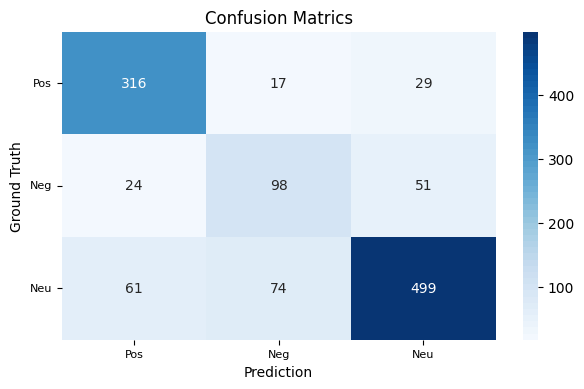

In [17]:
def confusion_matrix(y_test, y_pred):
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    from sklearn.metrics import confusion_matrix
    plt.figure(figsize=(7, 4))

    heatmap = sns.heatmap(
        data=pd.DataFrame(confusion_matrix(y_test, y_pred)),
        annot=True,
        fmt="d",
        cmap=sns.color_palette("Blues", 50),
    )
    x_axis_labels = ["Pos","Neg","Neu"]
    y_axis_labels = ["Pos","Neg","Neu"]
    # heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), fontsize=14)
    heatmap.xaxis.set_ticklabels(x_axis_labels, fontsize=8)
    # heatmap.yaxis.set_ticklabels(
    #     heatmap.yaxis.get_ticklabels(), rotation=0, fontsize=14
    # )
    heatmap.yaxis.set_ticklabels(y_axis_labels, rotation=0, fontsize=8)

    plt.title("Confusion Matrics")
    plt.ylabel("Ground Truth")
    plt.xlabel("Prediction")

confusion_matrix(label_ids, preds)

## Accuracy

Accuracy            : 0.7810
Precision(macro)    : 0.7228
Recall(macro)       : 0.7422
F1 Score(macro)     : 0.7308
Precision(weighted) : 0.7882
Recall(weighted)    : 0.7810
F1 Score(weighted)  : 0.7828

-------------------------------------------------------------


Class		: positive
Precision	: 0.7880
Recall		: 0.8729
F1 Score	: 0.8283

Class		: negative
Precision	: 0.5185
Recall		: 0.5665
F1 Score	: 0.5414

Class		: neutral
Precision	: 0.8618
Recall		: 0.7871
F1 Score	: 0.8228


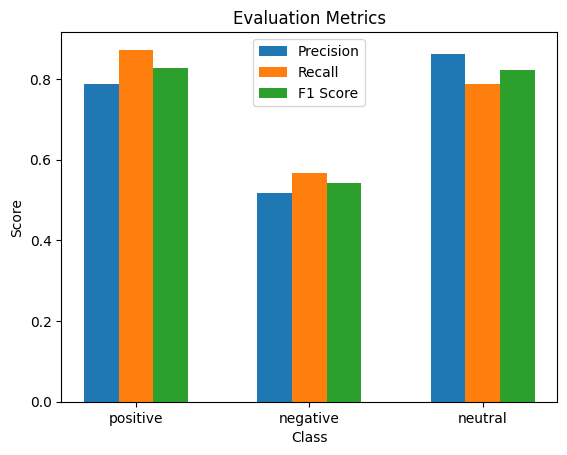

In [14]:
def my_eval(y_test, y_pred):
    import matplotlib.pyplot as plt
    from sklearn.metrics import (
        accuracy_score,
        precision_score,
        recall_score,
        f1_score
    )
    # define class
    class_names = ['positive','negative', 'neutral']

    # model eval
    accuracy = accuracy_score(y_test, y_pred)
    
    precision = precision_score(y_test, y_pred, average=None)
    recall = recall_score(y_test, y_pred, average=None)
    f1 = f1_score(y_test, y_pred, average=None)
    
    precision_macro = precision_score(y_test, y_pred, average='macro')
    recall_macro = recall_score(y_test, y_pred, average='macro')
    f1_macro = f1_score(y_test, y_pred, average='macro')
    
    precision_weighted = precision_score(y_test, y_pred, average='weighted')
    recall_weighted = recall_score(y_test, y_pred, average='weighted')
    f1_weighted = f1_score(y_test, y_pred, average='weighted')

    print("Accuracy            : {:.4f}".format(accuracy))
    print("Precision(macro)    : {:.4f}".format(precision_macro))
    print("Recall(macro)       : {:.4f}".format(recall_macro))
    print("F1 Score(macro)     : {:.4f}".format(f1_macro))

    print("Precision(weighted) : {:.4f}".format(precision_weighted))
    print("Recall(weighted)    : {:.4f}".format(recall_weighted))
    print("F1 Score(weighted)  : {:.4f}".format(f1_weighted))


    print("\n-------------------------------------------------------------\n")
    
    for i, class_name in enumerate(class_names):
        print("\nClass\t\t: {}".format(class_name))
        print("Precision\t: {:.4f}".format(precision[i]))
        print("Recall\t\t: {:.4f}".format(recall[i]))
        print("F1 Score\t: {:.4f}".format(f1[i]))

    x_pos = np.arange(len(class_names))

    plt.bar(x_pos, precision, width=0.2, label='Precision')
    plt.bar(x_pos + 0.2, recall, width=0.2, label='Recall')
    plt.bar(x_pos + 0.4, f1, width=0.2, label='F1 Score')

    plt.xticks(x_pos + 0.2, class_names)
    plt.xlabel('Class')
    plt.ylabel('Score')
    plt.title('Evaluation Metrics')
    plt.legend()

    plt.show()

    
my_eval(label_ids, preds)

# finbert-tone

Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


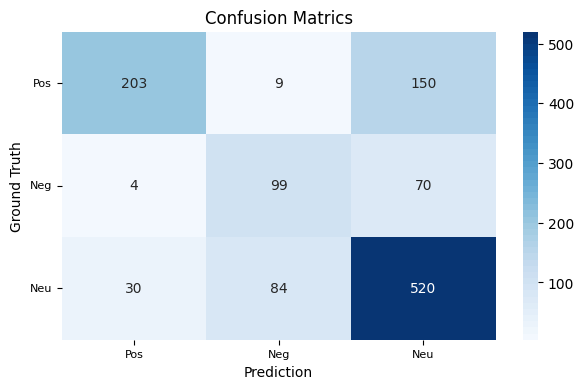

In [15]:
from transformers import pipeline
finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

nlp = pipeline("sentiment-analysis", model=finbert, tokenizer=tokenizer)

sentences = df_test['Sentence'].to_list()
results = nlp(sentences)

# Define a mapping for label to numerical value
label_mapping = {'Positive': 0, 'Negative': 1, 'Neutral': 2}

# Convert labels to numerical values
label_values = [label_mapping[pred['label']] for pred in results]

# define y_test and y_test_predictions for evaluation
y_test = df_test['label'].to_list()
y_pred = label_values

# confusion matrics
confusion_matrix(y_test, y_pred)


Accuracy            : 0.7032
Precision(macro)    : 0.6916
Recall(macro)       : 0.6511
F1 Score(macro)     : 0.6591
Precision(weighted) : 0.7227
Recall(weighted)    : 0.7032
F1 Score(weighted)  : 0.7007

-------------------------------------------------------------


Class		: positive
Precision	: 0.8565
Recall		: 0.5608
F1 Score	: 0.6778

Class		: negative
Precision	: 0.5156
Recall		: 0.5723
F1 Score	: 0.5425

Class		: neutral
Precision	: 0.7027
Recall		: 0.8202
F1 Score	: 0.7569


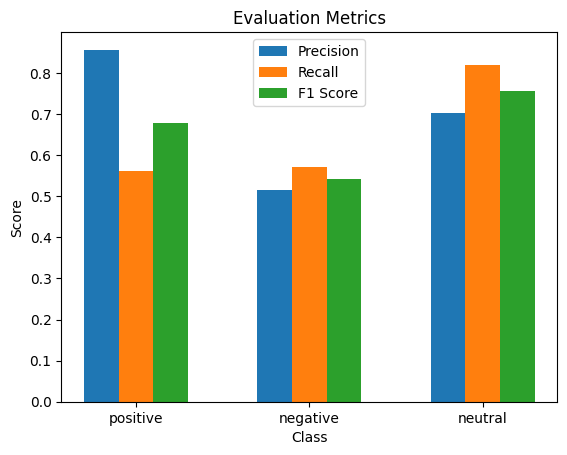

In [16]:
my_eval(y_test, y_pred)